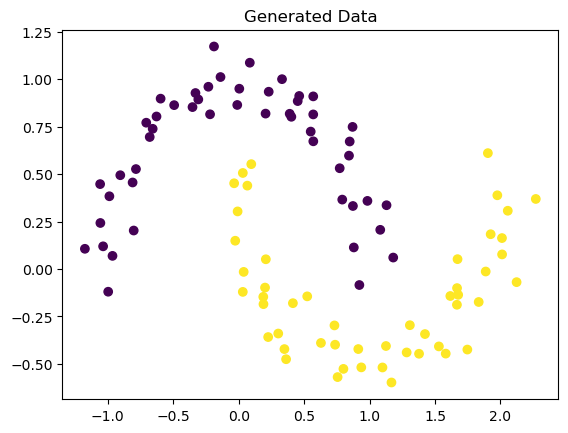

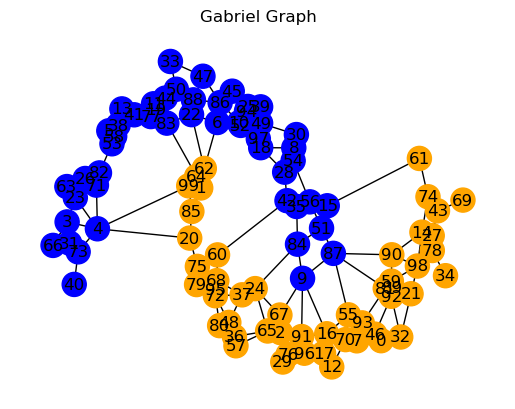

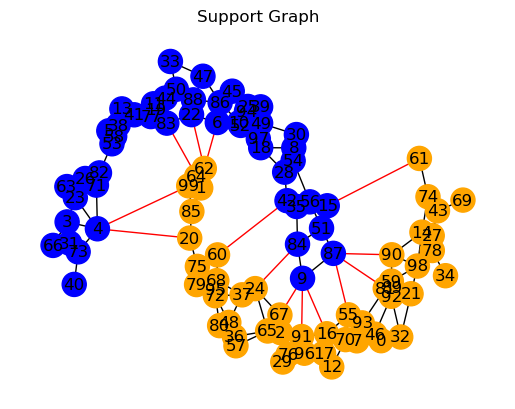

In [ ]:
# %%
import numpy as np
from enum import Enum
from sklearn.datasets import make_moons
import networkx as nx
import matplotlib.pyplot as plt

def sq_distance(a: np.ndarray, b: np.ndarray) -> float:
  """
  Calculate the squared distance between two vectors.
  
  Parameters:
  a (np.ndarray): First vector.
  b (np.ndarray): Second vector.
  
  Returns:
  float: Squared distance between the two vectors.
  """
  return np.sum((a - b) ** 2)

def distance_matrix(a: np.ndarray, b: np.ndarray) -> np.ndarray:
  """
  Calculate the distance matrix between two sets of vectors using vectorization.
  
  Parameters:
  a (np.ndarray): First set of vectors.
  b (np.ndarray): Second set of vectors.
  
  Returns:
  np.ndarray: Distance matrix where element (i, j) is the squared distance between a[i] and b[j].
  """
  return np.sum((a[:, np.newaxis] - b) ** 2, axis=2)

class Adjacency(Enum):
  NOT_ADJACENT = 0
  GABRIEL_EDGE = 1
  SUPPORT_EDGE = 2

def gabriel_graph(distance_matrix: np.ndarray) -> np.ndarray:
  """
  Create a Gabriel graph from a distance matrix using the correct condition.
  
  Parameters:
  distance_matrix (np.ndarray): Squared distance matrix.
  
  Returns:
  np.ndarray: Adjacency matrix of the Gabriel graph.
  """
  n = distance_matrix.shape[0]
  adjacency_matrix = np.zeros((n, n), dtype=Adjacency)
  
  for i in range(n):
    for j in range(i + 1, n):
      d_ij = distance_matrix[i, j]
      valid = True
      for k in range(n):
        if k == i or k == j:
          continue
        d_ik = distance_matrix[i, k]
        d_jk = distance_matrix[j, k]
        if (d_ik + d_jk) < d_ij:
          valid = False
          break
      if valid:
        adjacency_matrix[i, j] = Adjacency.GABRIEL_EDGE
        adjacency_matrix[j, i] = Adjacency.GABRIEL_EDGE
  return adjacency_matrix

def support_graph(gabriel_graph: np.ndarray, y: np.ndarray) -> np.ndarray:
  """
  Create a support graph from a Gabriel graph and the vector of labels.
  
  Parameters:
  gabriel_graph (np.ndarray): Adjacency matrix of the Gabriel graph.
  y (np.ndarray): Vector of labels.
  
  Returns:
  np.ndarray: Adjacency matrix of the support graph with enum values.
  """
  n = gabriel_graph.shape[0]
  support_graph = np.zeros((n, n), dtype=Adjacency)
  
  for i in range(n):
    for j in range(i + 1, n):
      if gabriel_graph[i, j]:
        if y[i] != y[j]:
          support_graph[i, j] = Adjacency.SUPPORT_EDGE
          support_graph[j, i] = Adjacency.SUPPORT_EDGE
        else:
          support_graph[i, j] = Adjacency.GABRIEL_EDGE
          support_graph[j, i] = Adjacency.GABRIEL_EDGE
      else:
        support_graph[i, j] = Adjacency.NOT_ADJACENT
        support_graph[j, i] = Adjacency.NOT_ADJACENT
  return support_graph

def plot_graph(X: np.ndarray, graph: np.ndarray, y: np.ndarray) -> None:
  """
  Plot a graph with vertices colored based on labels and edges colored based on their type.

  Parameters:
  X (np.ndarray): Coordinates of the vertices.
  graph (np.ndarray): Adjacency matrix of the graph.
  y (np.ndarray): Labels for the vertices.
  """
  G = nx.Graph()
  pos = {i: (X[i, 0], X[i, 1]) for i in range(len(X))}

  # Add nodes with colors based on labels
  for i in range(len(X)):
    G.add_node(i, color='blue' if y[i] == 0 else 'orange')

  # Add edges with colors based on edge type
  for i in range(len(graph)):
    for j in range(i + 1, len(graph)):
      if graph[i, j] == Adjacency.GABRIEL_EDGE:
        G.add_edge(i, j, color='black')
      elif graph[i, j] == Adjacency.SUPPORT_EDGE:
        G.add_edge(i, j, color='red')

  # Extract node and edge colors
  node_colors = [data['color'] for _, data in G.nodes(data=True)]
  edge_colors = [data['color'] for _, _, data in G.edges(data=True)]

  # Plot the graph
  nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, node_size=10)
  plt.show()


# Generate sample data
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Generated Data")
plt.show()

# Compute distance matrix and Gabriel graph
dm = distance_matrix(X, X)
gg = gabriel_graph(dm)

# Compute support graph
sg = support_graph(gg, y)

# Plot the Gabriel graph
plt.title("Gabriel Graph")
plot_graph(X, gg, y)

# Plot the support graph
plt.title("Support Graph")
plot_graph(X, sg, y)